# Zonal Mean Layer Cloud

Use the catalogs along with derived variable registry for loading data.

This notebook provides a way to plot the layer cloud amounts from any of the satellite products (as long as they're in the catalog).

In [21]:
import ast
import intake
import intake_esm
from intake_esm import DerivedVariableRegistry
from pathlib import Path

import computations as comp

import xarray as xr
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr
import cartopy.crs as ccrs

import colorcet as cc

import plotting_methods as plm

In [2]:
#
# parameters should go here
#
satellite = "CALIPSO" # "ISCCP" #  
variables_to_plot = [c+satellite.lower() for c in ["clt", "clh", "clm", "cll"]]
print(variables_to_plot)
labels = ["Total Cloud Cover", "High Cloud Cover", "Mid-level Cloud Cover", "Low Cloud Cover"]
vtitlestring = {v:labels[i] for i, v in enumerate(variables_to_plot)}
# land mask for CESM grid:
land = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")['LANDFRAC']

['cltcalipso', 'clhcalipso', 'clmcalipso', 'cllcalipso']


In [26]:
# dict of catalogs to use
rootdir = Path("/Volumes/Drudonna/")
catsfils = {
    "CAM4": rootdir / "cam4_1deg_release_amip" / "catalog" / "catalog_cam4_1deg_release_amip.json",
    "CAM5": rootdir / "cam5_1deg_release_amip" / "catalog" / "catalog_cam5_1deg_release_amip.json",
    "CAM6": rootdir / "f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1" / "catalog" / "catalog_f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.json",
    "E3SM": rootdir / "E3SM-1-0_amip" / "catalog" / "catalog_E3SM-1-0_amip.json",
    "OBS" : rootdir / "catalog_satellite_clouds_monthly.json"
}

# also define the derived variable registry:
dvr_objs = {"CAM4":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM5":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM6":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "E3SM":DerivedVariableRegistry.load("e3sm_derived_variable_registry"),
           "OBS":None}

csv_kw = {"CAM4":None, "CAM5":None, "CAM6":None, "E3SM":None, "OBS":{"converters": {"variable": ast.literal_eval}}}

print("CATS")
cats = {c: intake.open_esm_datastore(str(catsfils[c]), registry=dvr_objs[c], read_csv_kwargs=csv_kw[c]) for c in catsfils}

print("CATS_SUBSET")
cats_subset = {}
for c in cats:
    if c == 'E3SM':
        cats_subset[c] = cats[c].search(variable=variables_to_plot, member_id="r1i1p1f1")
    else:
        try:
            cats_subset[c] =  cats[c].search(variable=variables_to_plot)
        except Exception:
            print(f"Sorry -- search failed for {c}")

print("DSETS (a)")
dsets = {}
for c in cats_subset:
    dcod = True if c == "OBS" else False
    tmp = cats_subset[c].to_dataset_dict(xarray_open_kwargs={"decode_times": dcod}, xarray_combine_by_coords_kwargs={'coords':'minimal','compat':'override'})
    if len(tmp.keys()) == 1:
        if c == 'OBS':
            dsets[list(tmp.keys())[0]] = tmp[list(tmp.keys())[0]]
        else:
            dsets[c] = tmp[list(tmp.keys())[0]] # call it CAM/E3SM
    elif c == 'E3SM':
        dsets[c] = xr.merge(tmp.values())
    else:
        dsets = {**dsets, **tmp} # adds ISCCP/MISR/MODIS as keys

print("DSETS (b)")
dsets = {c: dsets[c].load() for c in dsets}

print("DSETS (c)")
for dsn in dsets:
    if 'time_bnds' in dsets[dsn]:
        bnddim = [d != 'time' for d in dsets[dsn].time_bnds.dims].index(True)
        tmptime = dsets[dsn]['time_bnds'].mean(dim=dsets[dsn].time_bnds.dims[bnddim])
        tmptime.attrs = dsets[dsn]['time'].attrs
        dsets[dsn] = dsets[dsn].assign_coords({"time":tmptime})
        dsets[dsn] = xr.decode_cf(dsets[dsn])
    else:
        print(f"Did not find `time_bnds` in dataset {dsn}")

print("CHECKS")
#
# hard-code a change in cltcalipso to percent
#
if satellite == 'CALIPSO':
    for v in variables_to_plot:
        dsets['CALIPSO'][v] = 100.*dsets['CALIPSO'][v]
        dsets['CALIPSO'][v].attrs['units'] = "percent"

remove_saa = False
if remove_saa and satellite == 'CALIPSO':
    for v in variables_to_plot:
        dsets['CALIPSO'][v].loc[{"lat": (dsets['CALIPSO']['lat'] > -49) & (dsets['CALIPSO']['lat'] < -1), "lon": (dsets['CALIPSO']['lon'] > 360-99)&(dsets['CALIPSO']['lon']<359)}] = np.nan
        print("got it!")


CATS
CATS_SUBSET
DSETS (a)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source'


DSETS (b)
DSETS (c)
Did not find `time_bnds` in dataset CALIPSO
CHECKS


/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/zonal_mean_layercloud_CALIPSO_2000-2015.pdf
File already exists ... specify whether to overwrite: True.


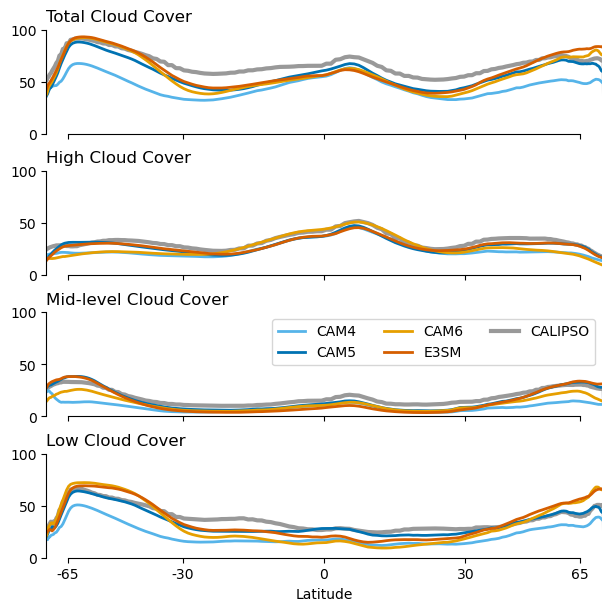

In [28]:
fig, ax = plt.subplots(figsize=(6,6),nrows=4, sharex=True, constrained_layout=True)

opts = {"CAM4":{"color":"#56B4E9","linewidth":2},
"CAM5":{"color":"#0072B2", "linewidth":2},
"CAM6":{"color":"#E69F00", "linewidth":2},
"E3SM":{"color":"#D55E00", "linewidth":2},
"CALIPSO":{"color":"#999999", "linewidth":3, "zorder":0},
"ISCCP":{"color":"#999999", "linewidth":3, "zorder":0}}

time_sample = True
if time_sample:
    start_time = "2000-01-01"
    end_time = "2015-12-31"
    tslice = slice(start_time, end_time)
    tstr = f"{start_time[0:4]}-{end_time[0:4]}"
else:
    tslice = slice(None,None)
    tstr = "alltime"

for i, v in enumerate(variables_to_plot):
    for src in dsets:
        lat = dsets[src][v].lat
        sinlat = np.sin(np.radians(lat))
        tmp = comp.month_avg(dsets[src][v].sel(time=tslice)).mean(dim='lon')
        ax[i].plot(sinlat, tmp, label=src, **opts[src])
        ax[i].set_title(vtitlestring[v], loc='left')

ax[-2].legend(ncol=3)
[a.spines['top'].set_visible(False) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]
[a.set_ylim([0,100]) for a in ax]
[a.set_xlim([np.sin(np.radians(-79)), np.sin(np.radians(79))]) for a in ax]
[a.set_xticks(np.sin(np.radians([-65, -30, 0, 30, 65]))) for a in ax]
[a.set_xticklabels([-65, -30, 0, 30, 65]) for a in ax]
ax[-1].set_xlabel("Latitude")
[a.spines.bottom.set_bounds((np.sin(np.radians(-65)), np.sin(np.radians(65)))) for a in ax]
# fig.suptitle(satellite)
if remove_saa and satellite == 'CALIPSO':
    tstr += "_removeSAA"
plotfilename = f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/zonal_mean_layercloud_{satellite}_{tstr}.pdf"
print(plotfilename)
plm.fig_output(fig, plotfilename, clobber_fig=True)
